In [1]:
using LowRankModels
using PyPlot
using CSV
using ProgressMeter
using Statistics
using StatsBase
using LaTeXStrings
using Printf
using ScikitLearn.CrossValidation: KFold
using JLD2

# Load Henry coefficient matrix `H`

see `CreateMatrix.ipynb` for Python code that queries the NIST database for the adsorption data and fits Henry's law to the adsorption data to identify the Henry constant.

the gases run along the columns, the materials run along the rows, and the entries are the Henry coefficients identified from experimental adsorption data.

In [2]:
@load joinpath("data", "logH_matrix_materials_and_gases.jld2") new_H master_list_of_materials master_list_of_gases
H = deepcopy(new_H) # log(H)
materials = String.(deepcopy(master_list_of_materials)) # list of materials, order corresponding to rows in H
gases = String.(deepcopy(master_list_of_gases)) # list of gases, order corresponding to cols in H

nm, ng = size(H) #no. of materials and gases

@assert length(materials) == nm && length(gases) == ng

In [3]:
H

101×34 Array{Union{Missing, Float64},2}:
 1.07291    missing   missing   0.608912  …  -1.24215    missing   missing
  missing   missing   missing   0.407258       missing   missing   missing
  missing   missing   missing    missing       missing   missing   missing
  missing   missing   missing    missing       missing   missing   missing
 0.979586   missing   missing    missing     -1.70722   2.96597    missing
  missing   missing   missing    missing  …  -0.959487   missing   missing
  missing   missing   missing    missing     -1.59054    missing   missing
  missing   missing   missing    missing       missing   missing   missing
  missing   missing   missing   0.439708     -1.26242    missing   missing
  missing   missing   missing    missing     -2.4795     missing   missing
  missing   missing   missing    missing  …    missing   missing   missing
  missing  0.469177   missing    missing       missing   missing   missing
 1.0161     missing   missing   1.54251      -1.4129     mi

In [4]:
sum(ismissing.(H))/length(H)

0.7894583576004659

## sort rows, cols according to the number of observations
... and sort `materials` and `gases` accordingly!

In [5]:
function sort_rows_cols_acc_to_nb_obs!(H::Array{Union{Float64, Missing}, 2}, 
                                       materials::Array{String, 1}, 
                                       gases::Array{String, 1})
    # rows
    nb_obs = [sum(.! ismissing.(H[i, :])) for i = 1:nm]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[ids_reorder, :]
    materials .= materials[ids_reorder]

    # cols
    nb_obs = [sum(.! ismissing.(H[:, j])) for j = 1:ng]
    ids_reorder = sortperm(nb_obs, rev=true)
    H .= H[:, ids_reorder]
    gases .= gases[ids_reorder]

    # sanity check
    @assert sum(ismissing.(H[:, 1])) <= sum(ismissing.(H[:, 3])) # first row has fewer missing values
    @assert sum(ismissing.(H[1, :])) <= sum(ismissing.(H[3, :])) # first col has fewer missing values
    return nothing
end

sort_rows_cols_acc_to_nb_obs!(H, materials, gases)

## prune matrix by selecting rows/cols with the most observations

In [6]:
# nm = 20
# ng = 10

# H = H[1:nm, 1:ng]
# materials = materials[1:nm]
# gases = gases[1:ng];

# sort_rows_cols_acc_to_nb_obs!(H, materials, gases)
# println("min # observations in a row: ", sum(.! ismissing.(H[end, :])))
# println("min # observations in a col: ", sum(.! ismissing.(H[:, end])))
# # TODO copy Arni's code for viz of frequency of observations gases and mofs

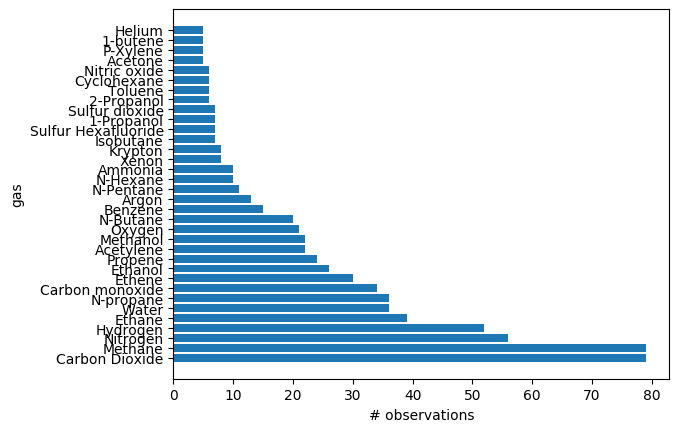

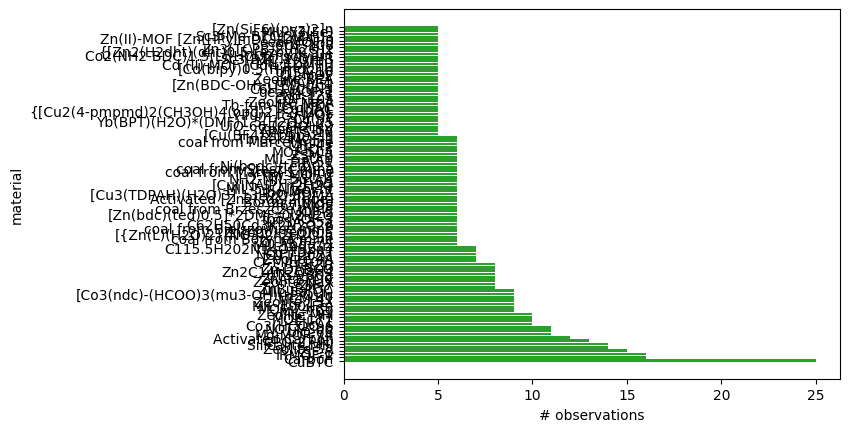

PyObject Text(24.000000000000043, 0.5, 'material')

In [7]:
plt.figure()
barh(gases, [sum(.! ismissing.(H[:, j])) for j = 1:ng])
xlabel("# observations")
ylabel("gas")

plt.figure()
barh(materials, [sum(.! ismissing.(H[i, :])) for i = 1:nm], color="C2")
xlabel("# observations")
ylabel("material")

## standardize columns
* standardize the columns (representing $H$'s for a certain gas) so that each column has mean zero and variance of one

In [8]:
# standardize the columns
for j = 1:ng
    # find ids that are not missing
    ids = .! ismissing.(H[:, j])
    # Hij <-- (Hij - μ_j) / σ_j 
    H[:, j] .= (H[:, j] .- mean(H[ids, j])) ./ std(H[ids, j])
end
# Udell ?: does it make sense to normalizes gases but not MOFs? 
#  Cory's justification: gases exhibit tons of variance in the means

In [9]:
H

101×34 Array{Union{Missing, Float64},2}:
  0.355507    0.455457   -0.0205382   …    missing   missing    missing
 -0.180394   -0.071465    0.00185209       missing   missing    missing
 -0.592826   -0.218563   -0.289475         missing   missing    missing
 -0.963495   -0.511264   -0.564917       -1.11321    missing    missing
  2.40459     0.543613    0.239234         missing  0.216859  -0.56846 
   missing    1.22848     0.0202627   …    missing   missing   1.68588 
  1.6708      0.724518    0.725509         missing   missing    missing
  0.203068    0.654539    0.0335091        missing   missing   0.144951
  2.19074     0.911736    0.612076         missing   missing    missing
 -0.0903608   0.112214   -0.265413         missing   missing    missing
  0.588751   -0.773728   -0.37016     …    missing   missing    missing
 -2.11879    -3.21635      missing       -0.96871    missing    missing
   missing    0.189043     missing         missing   missing    missing
  ⋮                    

## visualize

here, a diverging colormap is appropriate since the columns are standardized.

In [32]:
spy_H = deepcopy(H')
#spy_H[ismissing.(H)] .= 0.0

fig, ax = subplots(figsize=(10, 10))
img = ax.pcolormesh(spy_H, cmap="PiYG")#, 
    #vmax=maximum(abs.(spy_H)), vmin=-maximum(abs.(spy_H)))
cbar = colorbar(img, label=L"standardized $log_{10}(H_{ij})$", shrink=0.4)
# grid lines
for x = 1:nm
    plot([0, ng], [x, x], linewidth=0.55, color="gray")
end
for y = 1:ng
    plot([y, y ], [0, nm], linewidth=0.55, color="gray")
end
ax.set_aspect("equal")
title("material-gas matrix")
xlabel("gases")
ylabel("materials")
# TODO make missing values black to distinguish between actual 0 and missing.
# TODO xticks, yticks with material and gas names
xticks(collect(1:ng) .- 0.5, gases, rotation=90)
yticks(collect(1:nm) .- 0.5, materials);

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/sturlusa/.julia/packages/PyCall/ttONZ/src/pyfncall.jl:44 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError("'<=' not supported between instances of 'float' and 'PyCall.jlwrap'",)
  File "/home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/__init__.py", line 1599, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py", line 6188, in pcolormesh
    collection.autoscale_None()
  File "/home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/cm.py", line 393, in autoscale_None
    self.norm.autoscale_None(self._A)
  File "/home/sturlusa/.local/lib/python3.6/site-packages/matplotlib/colors.py", line 1001, in autoscale_None
    self.vmin = A.min()
  File "/home/sturlusa/.local/lib/python3.6/site-packages/numpy/core/_methods.py", line 34, in _amin
    return umr_minimum(a, axis, None, out, keepdims, initial, where)


## work with `H'`, i.e. transpose of `H` to add row offsets via `LowRankModels.jl`

In [11]:
H = collect(H')

34×101 Array{Union{Missing, Float64},2}:
  0.355507   -0.180394    -0.592826   …   0.858464   0.143416    missing
  0.455457   -0.071465    -0.218563       1.262     -1.66701     missing
 -0.0205382   0.00185209  -0.289475       0.275948    missing    missing
 -0.122361    0.0531926   -0.269442      -0.114384    missing  -1.20776 
  0.0801062  -0.125192    -0.210678        missing  -1.09851     missing
  0.439955   -1.92406     -1.69194    …  -0.316904    missing    missing
  0.612359     missing    -3.12394         missing  -0.925505    missing
  0.77269     0.343523    -0.0362222       missing    missing    missing
  1.06817     0.71663       missing        missing    missing    missing
  1.00546      missing      missing        missing    missing   0.266903
  1.23074      missing      missing   …    missing    missing    missing
  0.253766     missing    -0.456859        missing    missing    missing
  1.12602     0.603751      missing        missing    missing   0.314534
  ⋮       

# find the optimal low rank model through cross-validation

In [12]:
ids_obs = observations(H) # returns tuple of observations
nb_obs = length(ids_obs)
println("# observations = ", nb_obs)
println("fraction entries that are filled = ", nb_obs / nm / ng)

# observations = 723
fraction entries that are filled = 0.21054164239953407


### set up generalized low rank model for practice

we'll train on all data for practice to see how it works.

TODO: ask Prof. Udell why offsets are not regularized.

In [13]:
# k = rank of matrix
# γ = regularization param
# Udell: do we need to look at ch? does it tell us if it fails?
function fit_glrm(k::Int, γ::Float64, obs::Array{Tuple{Int64,Int64},1}; verbose::Bool=true)
    rg = QuadReg(γ) # quadratic regularizer on X, Y
    rm = QuadReg(γ * ng / nm)

    glrm = GLRM(H, QuadLoss(), rg, rm, k, obs=obs, offset=true)

    G, M, ch = fit!(glrm, ProxGradParams(max_iter=1000), verbose=verbose) # H' ~ G' * M well, our mathy H

    @assert isapprox(impute(glrm), G' * M)
    return G, M, glrm, ch
end

G, M, glrm, ch = fit_glrm(1, 30.0, ids_obs)

Fitting GLRM
Iteration 10: objective value = 406.21150987128755


([1.0 1.0 … 1.0 1.0], [0.5732410116483753 0.09437012355753889 … -0.7547269972982563 -0.16402025891242786], GLRM(Union{Missing, Float64}[0.35550669926865147 -0.1803939782559799 … 0.14341569906260263 missing; 0.4554567137281192 -0.07146501459145407 … -1.667008756207555 missing; … ; missing missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())  …  QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain())], Regularizer[lastentry1(QuadReg(30.0)), lastentry1(QuadReg(3

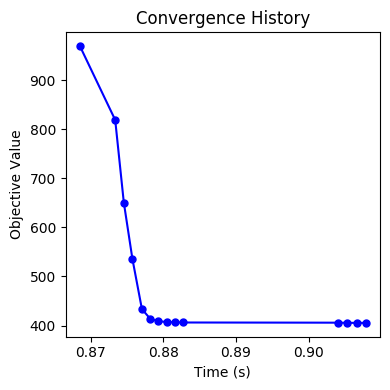

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(ch.times, ch.objective, color="b", marker="o", markersize=5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective Value")
ax.set_title("Convergence History")
plt.tight_layout()
plt.show()

### split the observations into `n_folds` folds.

TODO: ask Prof. Udell how this works when a MOF is missing from a row.

In [15]:
function k_fold_split(H::Array{Union{Missing, Float64}, 2}, k::Int; max_iter=1000)
    #@assert k > 1 "Choose a `k` greater than 1, otherwise this function is pointless"
    @printf("Splitting matrix into %d folds", k)

    fold_matrix = fill(0, size(H))
    all_k_folds_not_represented_in_each_column = true
    n_iteration = 0

    while all_k_folds_not_represented_in_each_column
        n_iteration += 1
        all_k_folds_not_represented_in_each_column = false
        for i_row = 1:size(H)[1]
            # Grabs all available indices in row `i_row`
            j_indices = findall(.!ismissing.(H[i_row,:]))
            # As long as there are enough data points to distribute between `k` folds, we'll equally distribute them.
            while length(j_indices) >= k
                for fold = 1:k
                    j = rand(1:length(j_indices))
                    fold_matrix[i_row, j_indices[j]] = fold
                    deleteat!(j_indices, j)
                end
            end
            # If there are leftover data points (i.e. #data points left < `k`), we'll randomly assign them into folds
            for j in j_indices
                items = collect(1:k)
                weights = [sum(fold_matrix[i_row, :] .!= _k .| fold_matrix[i_row, :] .!= 0) for _k = 1:k]
                fold_matrix[i_row, j] = sample(items, Weights(weights))
            end
        end
        # We make sure we have enough data points in the columns as well
        for j_col = 1:size(H)[2]
            unique_folds = unique(fold_matrix[:, j_col])
            if length(unique_folds) <= k
                all_k_folds_not_represented_in_each_column = true
                break
            end
        end

        # If too many iteration are performed an Exception is raised.
        if n_iteration >= max_iter
            error("Maximum number of iterations reached. Try changing the `max_iter` argument.")
        end
    end
    
    for i = 1:size(H)[1]
        for j = 1:size(H)[2]
            if ismissing(H[i,j])
                continue
            else
                @assert fold_matrix[i,j] != -1 "A non-NaN value was not put in a fold"
            end
        end
    end
    
    @printf("Number of iterations required to split data into %d-folds: %d\n", k, n_iteration)
    for fold = 1:k
        @printf("Number of data points in fold %d: %d\n", fold, sum(fold_matrix .== fold))
    end
    @printf("Total number of data points: %d\n", sum(.!ismissing.(H)))
    @printf("-----------------------------------\n")
    return fold_matrix
end

fold_matrix = k_fold_split(H, 3, max_iter=1000)
kfolds = [(findall(fold_matrix[:] .!= k), findall(fold_matrix[:] .== k)) for k = 1:length(unique(fold_matrix))-1]

Splitting matrix into 3 folds

ErrorException: Maximum number of iterations reached. Try changing the `max_iter` argument.

In [16]:
ids_obs

723-element Array{Tuple{Int64,Int64},1}:
 (1, 1)   
 (2, 1)   
 (3, 1)   
 (4, 1)   
 (5, 1)   
 (6, 1)   
 (7, 1)   
 (8, 1)   
 (9, 1)   
 (10, 1)  
 (11, 1)  
 (12, 1)  
 (13, 1)  
 ⋮        
 (4, 99)  
 (6, 99)  
 (1, 100) 
 (2, 100) 
 (5, 100) 
 (7, 100) 
 (15, 100)
 (4, 101) 
 (10, 101)
 (13, 101)
 (25, 101)
 (31, 101)

In [17]:
H

34×101 Array{Union{Missing, Float64},2}:
  0.355507   -0.180394    -0.592826   …   0.858464   0.143416    missing
  0.455457   -0.071465    -0.218563       1.262     -1.66701     missing
 -0.0205382   0.00185209  -0.289475       0.275948    missing    missing
 -0.122361    0.0531926   -0.269442      -0.114384    missing  -1.20776 
  0.0801062  -0.125192    -0.210678        missing  -1.09851     missing
  0.439955   -1.92406     -1.69194    …  -0.316904    missing    missing
  0.612359     missing    -3.12394         missing  -0.925505    missing
  0.77269     0.343523    -0.0362222       missing    missing    missing
  1.06817     0.71663       missing        missing    missing    missing
  1.00546      missing      missing        missing    missing   0.266903
  1.23074      missing      missing   …    missing    missing    missing
  0.253766     missing    -0.456859        missing    missing    missing
  1.12602     0.603751      missing        missing    missing   0.314534
  ⋮       

In [18]:
n_folds = 3 # K-fold cross validation
println("running $n_folds-cross validation...")
kfolds = KFold(nb_obs, n_folds=n_folds, shuffle=true);

running 3-cross validation...


visualize the fold matrix

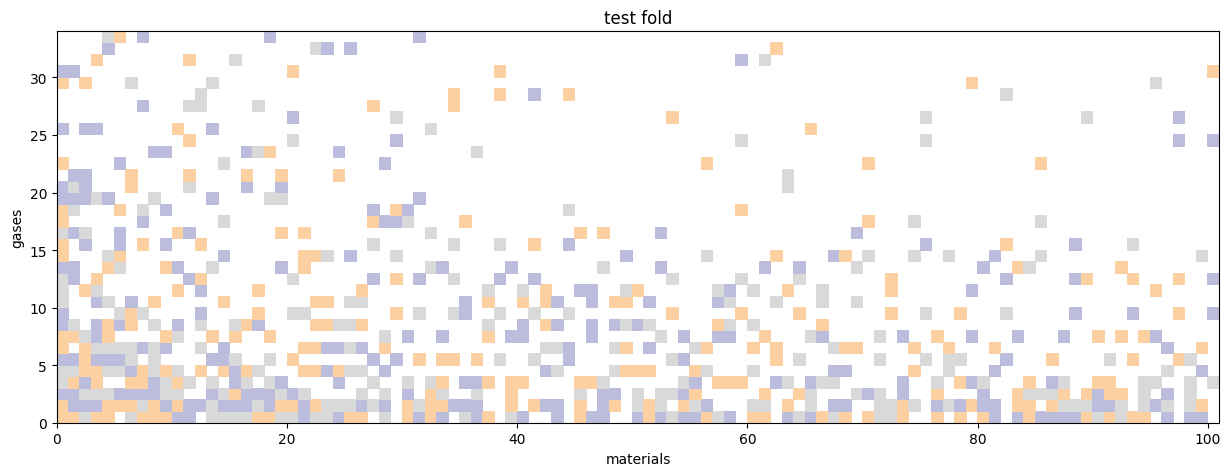

20


In [19]:
test_fold_matrix = Int.(zeros(size(H)))
for (i, fold) in enumerate(kfolds)
    for ix in fold[2]
        test_fold_matrix[ids_obs[ix][1], ids_obs[ix][2]] = i
    end
end

cmap = plt.get_cmap("tab20c")
colors = cmap(collect(1:cmap.N))
#colors = Array{Float64, 2}(undef, 6, 4)
colors[1, :] .= [0.0, 0.0, 0.0, 0.0] ./ 255
# colors[2, :] .= [128., 0., 0., 255.] ./ 255
# colors[3, :] .= [170., 255., 195., 255.] ./ 255
# colors[4, :] .= [145., 30., 180., 255.] ./ 255
# colors[5, :] .= [255., 250., 200., 255.] ./ 255
# colors[6, :] .= [0., 130., 200., 255.] ./ 255
println(cmap.N)
cmap = matplotlib.colors.ListedColormap(colors)

fig, ax = plt.subplots(figsize=(15, 15))
ax.pcolormesh(test_fold_matrix, cmap=cmap)
ax.set_aspect("equal")
ax.set_xlabel("materials")
ax.set_ylabel("gases")
ax.set_title("test fold")
#ax.set_xlabel("Fold Frequency")
# TODO put legend in there for the fold
plt.show()

## run cross-validation

specify the range of ranks and regularization params we aim to cover

In [20]:
ks = [1, 2, 3, 4, 5] # ranks
γs = 10.0 .^ range(0.0, 6.0, length=10); # regularization params

map rank to color for data visualizations

In [21]:
cmap = PyPlot.matplotlib.cm.viridis
norm = PyPlot.matplotlib.colors.Normalize(vmin=minimum(ks), vmax=maximum(ks))
rank_to_color = PyPlot.matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba

PyObject <bound method ScalarMappable.to_rgba of <matplotlib.cm.ScalarMappable object at 0x7fa34fff2a58>>

run `n_folds` cross validation, store test error for each $(k, \gamma)$ combo

In [22]:
# TODO ask Prof. Udell if it makes any sense to regularize X, Y separately

# progress meter
p = Progress(n_folds * length(ks) * length(γs))

mse = Dict(k => zeros(length(γs)) for k in ks) # store MSE for each regularization param and k

# loop over ranks
for (i_k, k) in enumerate(ks)
    # loop over regularization params
    for (i_γ, γ) in enumerate(γs)
        # loop over folds
        for (train_ids, test_ids) in kfolds
            # train model on training data
            G, M, glrm, ch = fit_glrm(k, γ, ids_obs[train_ids], verbose=false)
            
            # assess error on test data
            Ĥ = impute(glrm)
            H_pred = [Ĥ[i, j] for (i, j) in ids_obs[test_ids]]
            H_actual = [H[i, j] for (i, j) in ids_obs[test_ids]]
            mse[k][i_γ] += sum((H_pred .- H_actual) .^ 2) / length(test_ids)
            ProgressMeter.next!(p)
        end
    end
    mse[k] /= n_folds
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


visualize average `n_fold` test set error against regularization param $\gamma$ for different ranks

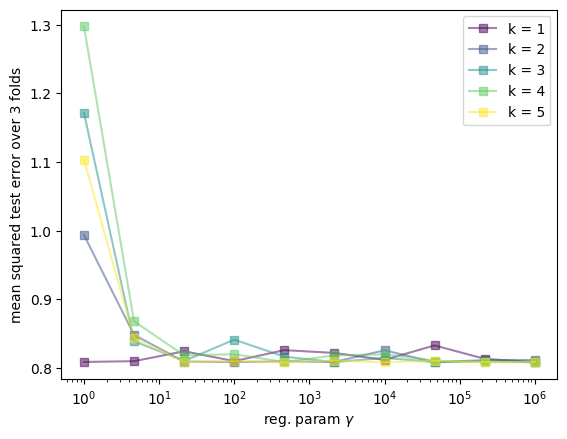

PyObject <matplotlib.legend.Legend object at 0x7fa34f4cc940>

In [23]:
figure()
xlabel(L"reg. param $\gamma$")
ylabel("mean squared test error over $n_folds folds")
for k in ks
    plot(γs, mse[k], label=@sprintf("k = %d", k), marker="s", color=rank_to_color(k), alpha=0.5)
end
xscale("log")
legend()
# Udell ?: should call when we only have MOF offsets, k = 0 or k = 1?
# Udell ?: if we are not regularizing the offsets, why is k=1 fixed? do we need to change max_iter or something?

## work with optimal model

In [24]:
min_mse = [minimum(mse[k]) for k in ks]
opt_k = ks[argmin(min_mse)] # optimum rank
opt_γ = γs[argmin(mse[opt_k])]

@show(min_mse)
@printf("optimum γ = %.3f, optimum k = %d\n", opt_γ, opt_k)

min_mse = [0.8081570583498682, 0.808067094571293, 0.8079305455204477, 0.8081999284877668, 0.8079157240355683]
optimum γ = 10000.000, optimum k = 5


### parity plot over `n_folds`-cross validation

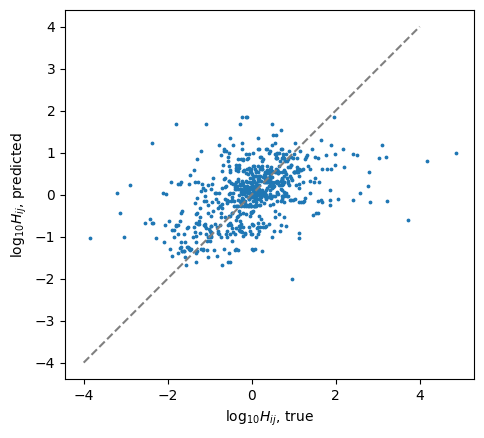

this_mse = 0.8084971910959925
R² = 0.15160599541015574
Numerator: 584.543
Denomirator: 689.000


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa34f6f0828>

In [25]:
H_actual = Float64[]
H_pred = Float64[]
this_mse = 0.0
for (train_ids, test_ids) in kfolds
    # train model on training data
    G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs[train_ids], verbose=false)
    
    # test
    Ĥ = impute(glrm)
    H_pred = vcat(H_pred, [Ĥ[i, j] for (i, j) in ids_obs[test_ids]])
    H_actual = vcat(H_actual, [H[i, j] for (i, j) in ids_obs[test_ids]])
    this_mse = sum((H_pred .- H_actual) .^ 2) / length(test_ids)
end

this_mse /= n_folds
@show(this_mse)

R² = 1 - sum((H_pred .- H_actual) .^ 2) / sum((H_actual .- mean(H_actual)) .^ 2)
@show R²
@printf("Numerator: %.3f\n", sum((H_pred .- H_actual) .^ 2))
@printf("Denomirator: %.3f\n", sum((H_actual .- mean(H_actual)) .^ 2))


fig, ax = subplots()
xlabel(L"$\log_{10} H_{ij}$, true")
ylabel(L"$\log_{10} H_{ij}$, predicted")
#hexbin(H_actual, H_pred, cmap="Greens", mincnt=1) #mincnt=1 makes bins white
scatter(H_actual, H_pred, s=3)
ax.set_aspect("equal")
plot([-4, 4], [-4, 4], linestyle="--", color="gray")

In [26]:
mean(H_pred)

0.020140227319953345

## viz offsets and latent space on fully trained model

In [27]:
G, M, glrm, ch = fit_glrm(opt_k, opt_γ, ids_obs, verbose=false)

([2.9653118791947365e-10 -1.380465345681121e-10 … -1.6240478592596685e-12 -2.4125682065324293e-12; 8.333474650661884e-11 -1.963773019046578e-11 … -6.890262386440856e-13 -1.7409033663026574e-12; … ; -1.420154103597082e-10 -4.5176887023014405e-10 … -1.1136489470905666e-13 -6.737009559579782e-13; 1.0 1.0 … 1.0 1.0], [-1.0261542851285045e-14 5.541365085401815e-15 … 1.176777667321718e-13 4.514685678997591e-14; -1.991555649562154e-15 -1.8543124455345975e-14 … 2.7668407847542804e-14 2.059226004280674e-14; … ; -6.680005712305195e-14 3.3575794244284235e-14 … 9.166610901467288e-14 -2.7853389177346393e-14; 0.5756499241448095 0.09473851811348466 … -0.7513756973434117 -0.16429312925699435], GLRM(Union{Missing, Float64}[0.35550669926865147 -0.1803939782559799 … 0.14341569906260263 missing; 0.4554567137281192 -0.07146501459145407 … -1.667008756207555 missing; … ; missing missing … missing missing; missing missing … missing missing], Loss[QuadLoss(1.0, RealDomain()), QuadLoss(1.0, RealDomain()), QuadL

### offsets $\mu_i$ representing material biases

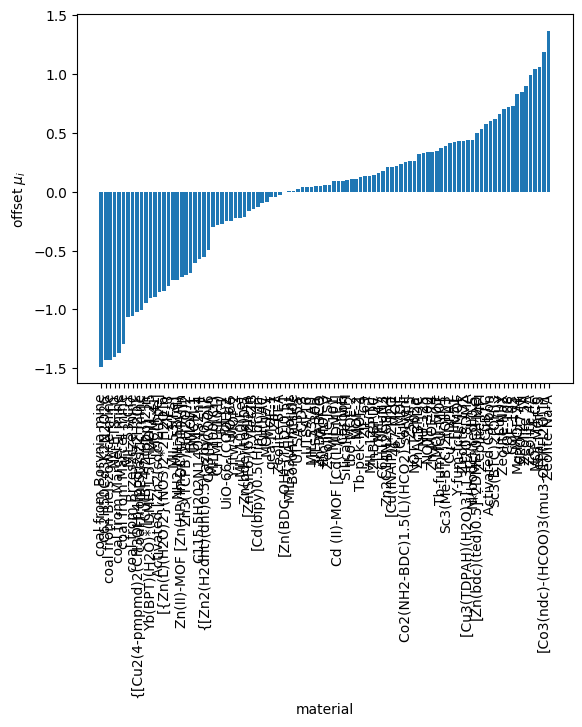

In [28]:
μ = M[end, :]

figure()
bar(1:nm, μ[sortperm(μ)])
xlabel("material")
ylabel(L"offset $\mu_i$")
xticks(1:nm, materials[sortperm(μ)], rotation=90);

### latent space of materials